In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!pip install tqdm

In [118]:
from tqdm import tqdm

## Import Data

In [3]:
users = pd.read_csv('takehome_users.csv')

In [5]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [6]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [47]:
engagement.count()

time_stamp    207917
user_id       207917
visited       207917
dtype: int64

In [16]:
#merge dataframes on user_id
data = pd.DataFrame.merge(users, engagement, how = 'left', left_on = 'object_id', right_on = 'user_id')

In [55]:
data.head()

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited
0,1,4/22/2014 3:53,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22,1.0
1,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15,1.0
2,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29,1.0
3,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09,1.0
4,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25,1.0


## Data Cleanup

In [17]:
#drop non-necessary columns
data = data.drop(columns = ['user_id', 'email', 'name'])

In [24]:
#change object_id column to user_id for readability
data.columns = ['user_id' if x=='object_id' else x for x in data.columns]

In [153]:
#convert time_stamp column datetime
data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [157]:
#since we're interested in sign-ins per week, omit time of day
data['time_stamp'] = data['time_stamp'].dt.date

In [155]:
#drop rows of users who signed up but never logged on
data.dropna(subset = ['time_stamp', 'visited'], inplace = True)

In [72]:
#create a running total of how many times a user has used the product
data['total_visits'] = data.groupby('user_id')['visited'].cumsum() 

In [162]:
#convert time of login to datetime format
data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [193]:
#set the login time as the index
#this is so that we can create a rolling window to count the number of user visits in a 7 day window
data3 = data.set_index('time_stamp')

In [194]:
#create a function that sums the values within 7 days of each event
#grouby user_id and then apply the function to visited column to get the total number of visits with the last 7 days of each login
f = lambda x: x.rolling('7d').sum()
data3['r_window'] = data3.groupby('user_id').visited.apply(f)

In [200]:
#verify window function is working correctly
data3.head(10)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,total_visits,r_window
time_stamp,,,,,,,,,,,
2014-04-22,1,4/22/2014 3:53,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,1.0,1.0
2013-11-15,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,1.0
2013-11-29,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,2.0,1.0
2013-12-09,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,3.0,1.0
2013-12-25,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,4.0,1.0
2013-12-31,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,5.0,2.0
2014-01-08,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,6.0,1.0
2014-02-03,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,7.0,1.0
2014-02-08,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,8.0,2.0


In [263]:
#create our target variable. An 'adopted_user' is defined as a customer who logged in at least 3 times within any 7 day period
data3['adopted_user'] = 0
data3['adopted_user'][data3['r_window'] >2] = 1

C:\Users\SReed\AppData\Local\Temp/ipykernel_22832/1080147615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['adopted_user'][data3['r_window'] >2] = 1


## Preprocesssing

In [214]:
#convert creation_source from a categorical variable into a numerical one via dummy variables
dummies = pd.get_dummies(data3['creation_source'])

In [218]:
dummies.head()

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
time_stamp,,,,,
2014-04-22,1,0,0,0,0
2013-11-15,0,1,0,0,0
2013-11-29,0,1,0,0,0
2013-12-09,0,1,0,0,0
2013-12-25,0,1,0,0,0


In [219]:
df = pd.concat([data3, dummies], axis= 1)

In [221]:
#Convert creation_time into days since login to use as a numerical variable in our analysis and model training
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['creation_time'] = df['creation_time'].dt.date

In [237]:
df['days_since_creation'] = (pd.Timestamp.today().date() - df['creation_time'])

In [238]:
d = lambda x: x.days
df['days_since_creation'] = df['days_since_creation'].apply(d)

In [240]:
#after replacing with numberical substitutes, drop categorical and time columns from the data frame
df.drop(columns =  ['creation_time', 'creation_source'], inplace = True)

## Correlation

In [241]:
matrix = data3.corr()

In [242]:
#examine correlation of each column with target
matrix.loc['adopted_user']

user_id                      -0.008956
last_session_creation_time    0.370584
opted_in_to_mailing_list     -0.005570
enabled_for_marketing_drip   -0.012589
org_id                        0.031526
invited_by_user_id           -0.003762
visited                            NaN
total_visits                  0.454657
r_window                      0.765048
adopted_user                  1.000000
Name: adopted_user, dtype: float64

<AxesSubplot:>

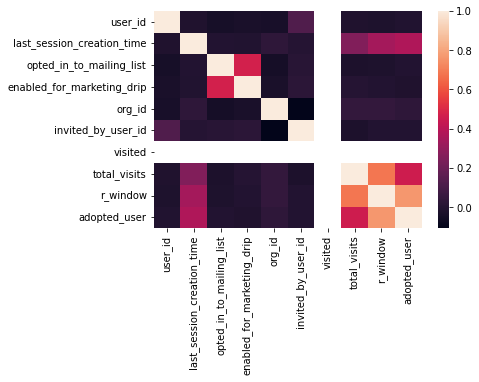

In [264]:
sns.heatmap(matrix)

## PCA

In [243]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [249]:
y = df['adopted_user']
X = df.drop(columns = ['adopted_user', 'invited_by_user_id'])

In [250]:
scaled_X = StandardScaler().fit_transform(X)

In [251]:
X_pca = PCA().fit(scaled_X)

Text(0.5, 1.0, 'Cumulative variance explained by PCA components')

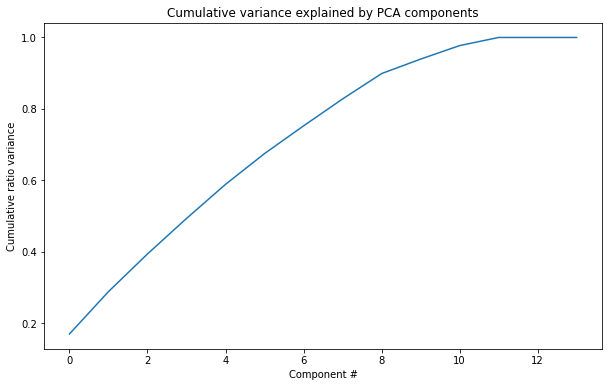

In [252]:
plt.subplots(figsize=(10, 6))
plt.plot(X_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance explained by PCA components')

In [253]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [260]:
df2 = df['adopted_user']
df2 = df2.reset_index()


In [261]:
PCA_df = pd.concat([principalDf, df2['adopted_user']], axis = 1)

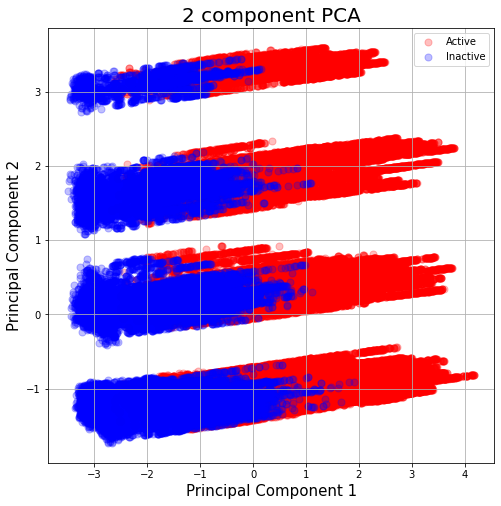

In [262]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = PCA_df['adopted_user'] == target
    ax.scatter(PCA_df.loc[indicesToKeep, 'principal component 1']
               , PCA_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = .25)
ax.legend(['Active', 'Inactive'])
ax.grid()

## Report

Two things stick out when we examine the data for Relax.

1. Perhaps most importantly, there is nearly zero correlation between users receiving marketing content or opting into the mailing list and becoming an adopted user. This raises a red flag that the outreach and marketing efforts are ineffective and are likely in need of review.

2. There is a slight positive correlation between the last session creation time and becoming an adopted user. Some further digging could be done to uncover whether it is the older or newer customers that are more likely to become adopted users. Then the question becomes, did something change in the product that caused new users to log in more or less frequently than old users?

There is also a very slight correlation with what organization the user is a part of, so it may be worth putting a little extra resources into targeting individuals who are part of a particular organization.